In [1]:
from utils import *
from extract_feature_AE import *
from extract_feature_PCA import *

c:\Users\quock\anaconda3\envs\QuocKhanh\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
np.random.seed(42)

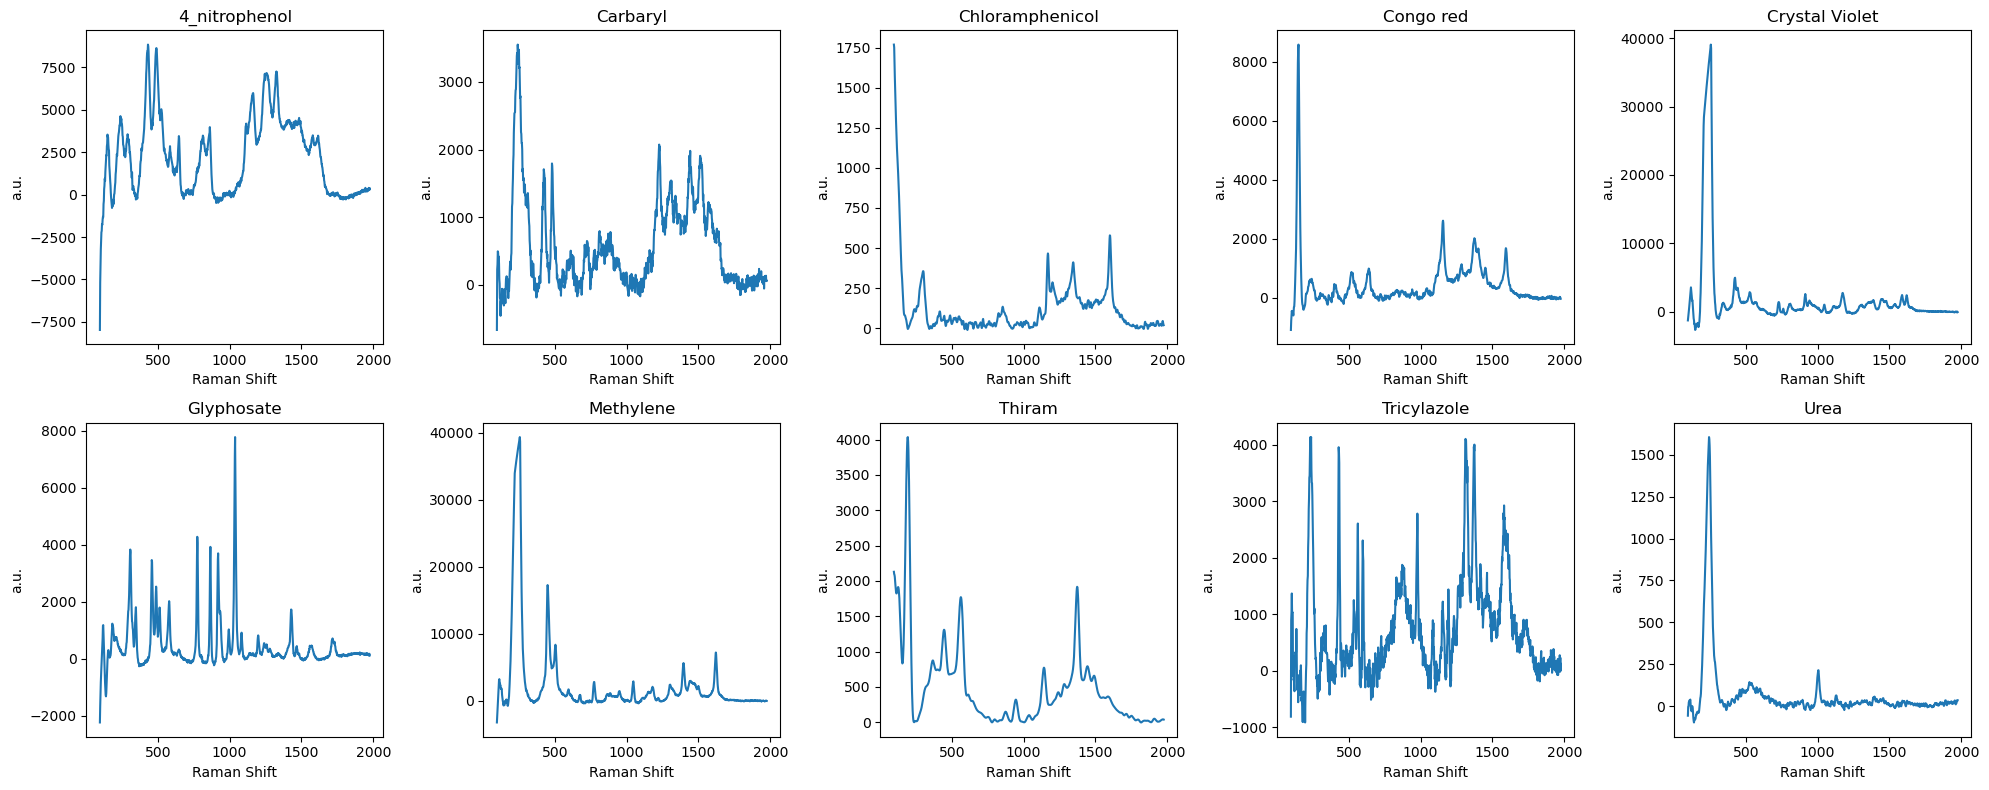

In [3]:
plot_data(paths, labels, file_names[0], 2, 5, figsize = (20, 8))

In [4]:
X, y = make_data(paths, 10)
print(X.shape, y.shape)
X_max = X.max(axis = 0, keepdims = True)
X_min = X.min(axis = 0, keepdims = True)

(50, 10) (50, 1)


In [5]:
X = Norm(X)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.4, stratify=y, shuffle= True, random_state= 42)

In [7]:
y_test

array([[0.],
       [9.],
       [3.],
       [4.],
       [8.],
       [5.],
       [2.],
       [4.],
       [6.],
       [5.],
       [2.],
       [9.],
       [7.],
       [3.],
       [0.],
       [1.],
       [8.],
       [6.],
       [1.],
       [7.]])

In [8]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(30, 10) (30, 1) (20, 10) (20, 1)


# Grid search

In [9]:
Grid_search_model(X_train,y_train, cv = 3)

Best parameters for Logistic Regression: {'C': 10.0, 'penalty': 'l1', 'solver': 'liblinear'}, score: 0.80
Time taken for Logistic Regression: 0.35 seconds

Best parameters for SVM: {'C': 10.0, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'shrinking': True}, score: 0.63
Time taken for SVM: 1.03 seconds

Best parameters for KNN: {'algorithm': 'auto', 'metric': 'cosine', 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}, score: 0.97
Time taken for KNN: 6.11 seconds

Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}, score: 0.60
Time taken for Decision Tree: 1.77 seconds

Best parameters for Random Forest: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200, 'random_state': 42}, score: 0.80
Time taken for Random Forest: 216.36 seconds

Best parameters for Naive Bayes: {'alpha': 0.01}, score: 0.10
Time taken for Naive Bayes

In [9]:
models = [LogisticRegression(C = 10, penalty = 'l1', solver = 'liblinear'),
          SVC(C = 10, degree = 2, gamma = 'scale', kernel = 'linear', shrinking = True,  probability=True),
          KNeighborsClassifier(algorithm = 'auto', metric = 'cosine', n_neighbors = 3, p = 1, weights = 'uniform'),
          DecisionTreeClassifier(criterion= 'entropy', max_depth= 4, min_samples_leaf= 1, min_samples_split = 2, splitter= 'best',  random_state = 42),
          RandomForestClassifier(criterion = 'gini', max_depth = 2, min_samples_leaf = 1, min_samples_split = 5, n_estimators = 200,  random_state = 42),
          BernoulliNB(alpha=0.1)]

In [10]:
for i, model in enumerate(models):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model.fit(X_train, y_train)
    file_name = f"./model/{type(models[i]).__name__}.pkl"
    save_model(file_name, model)


Model './model/LogisticRegression.pkl' already saved
Model './model/SVC.pkl' already saved
Model './model/KNeighborsClassifier.pkl' already saved
Model './model/DecisionTreeClassifier.pkl' already saved
Model './model/RandomForestClassifier.pkl' already saved
Model './model/BernoulliNB.pkl' already saved


Testing with LogisticRegression
Accuracy: 0.9000
Precision: 0.9500
Recall: 0.9000
F1-score: 0.9000
[9. 9. 3. 4. 8. 5. 2. 4. 6. 5. 2. 9. 7. 3. 0. 1. 8. 6. 1. 9.]
[[0. 9. 3. 4. 8. 5. 2. 4. 6. 5. 2. 9. 7. 3. 0. 1. 8. 6. 1. 7.]]


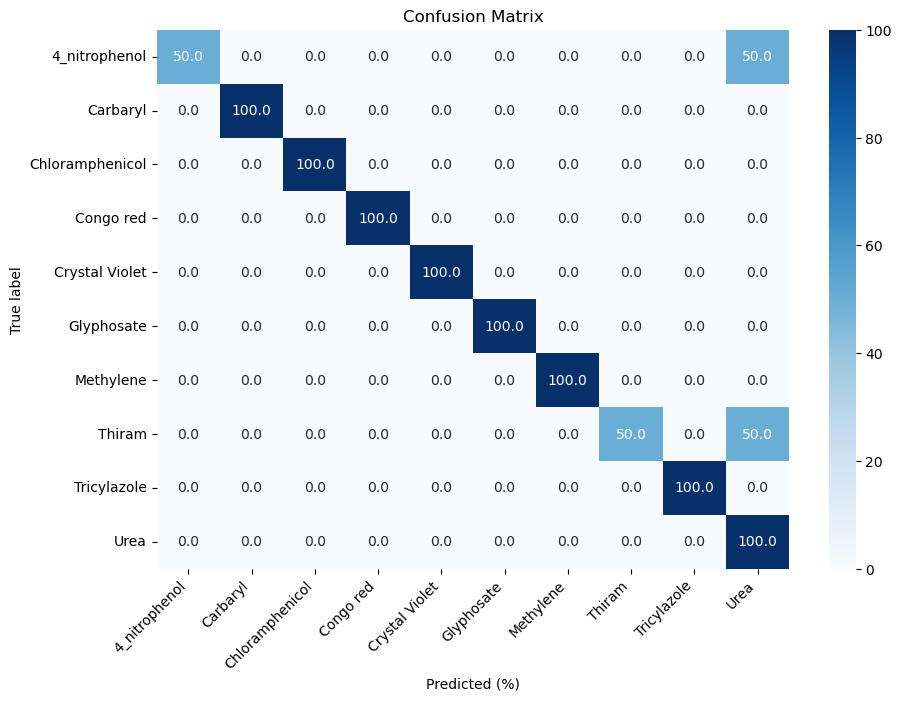

In [57]:
print(model_predict(X_test, y_test, models[0])['Predict'])
print(y_test.T)

# Ensemble

In [12]:
from sklearn.ensemble import VotingClassifier

ensemble_clf = VotingClassifier(
    estimators=[
        ('logistic', models[0]),
        ('svm', models[1]),
        ('knn', models[2]),
    ],
    voting='soft'
)

ensemble_clf.fit(X_train, y_train.ravel())



VotingClassifier(estimators=[('logistic',
                              LogisticRegression(C=10, penalty='l1',
                                                 solver='liblinear')),
                             ('svm',
                              SVC(C=10, degree=2, kernel='linear',
                                  probability=True)),
                             ('knn',
                              KNeighborsClassifier(metric='cosine',
                                                   n_neighbors=3, p=1))],
                 voting='soft')

Testing with VotingClassifier
Accuracy: 0.9500
Precision: 0.9667
Recall: 0.9500
F1-score: 0.9467
[0. 9. 3. 4. 8. 5. 2. 4. 6. 5. 2. 9. 7. 3. 0. 4. 8. 6. 1. 7.]
[[0. 9. 3. 4. 8. 5. 2. 4. 6. 5. 2. 9. 7. 3. 0. 1. 8. 6. 1. 7.]]


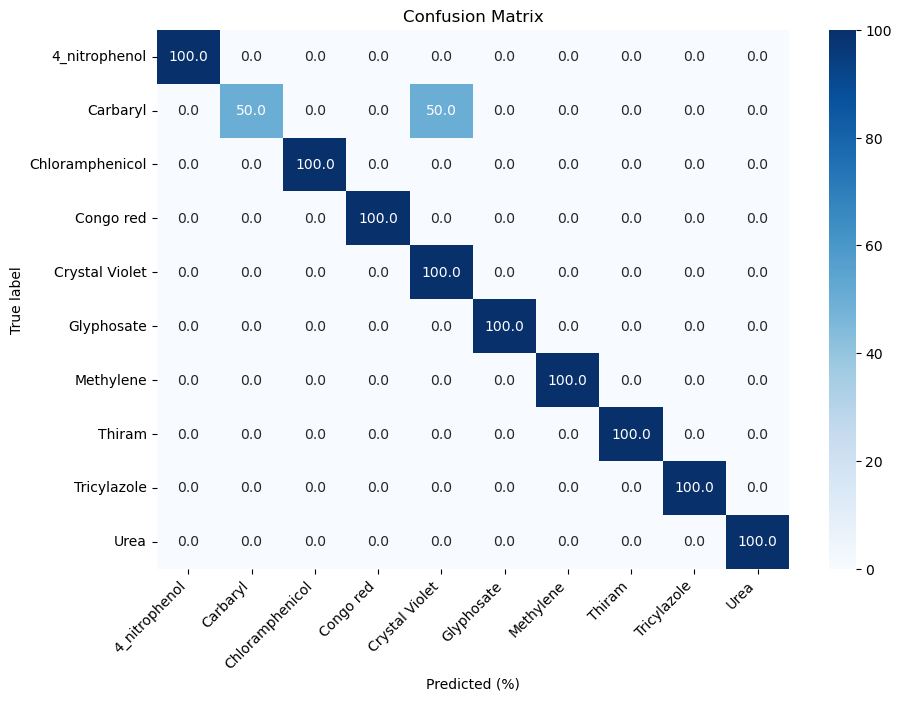

In [13]:
print(model_predict(X_test, y_test, ensemble_clf)['Predict'])
print(y_test.T)

In [14]:
proba = ensemble_clf.predict_proba(X_test)
proba[0]


array([0.4486535 , 0.03979649, 0.09175652, 0.04647616, 0.04186576,
       0.02097115, 0.08517504, 0.05785698, 0.01621546, 0.15123295])

# Testing

In [15]:
Trycilazole = ['test_Tricylazole/Tricyclazole-1.txt','test_Tricylazole/Tricyclazole-2.txt','test_Tricylazole/Tricyclazole-3.txt',
               'test_Tricylazole/Tricyclazole-4.txt','test_Tricylazole/Tricyclazole-5.txt']
for i in range(5):
    print(model_predict(X_test, y_test, models[0], path = Trycilazole[i])['Predict'])

Testing with LogisticRegression
[8.]
Testing with LogisticRegression
[8.]
Testing with LogisticRegression
[1.]
Testing with LogisticRegression
[1.]
Testing with LogisticRegression
[1.]


In [16]:
for i in range(5):
    print(model_predict(X_test, y_test, models[1], path = Trycilazole[i])['Predict'])

Testing with SVC
[8.]
Testing with SVC
[8.]
Testing with SVC
[8.]
Testing with SVC
[8.]
Testing with SVC
[8.]


In [17]:
for i in range(5):
    print(model_predict(X_test, y_test, models[2], path = Trycilazole[i])['Predict'])

Testing with KNeighborsClassifier
[8.]
Testing with KNeighborsClassifier
[8.]
Testing with KNeighborsClassifier
[8.]
Testing with KNeighborsClassifier
[8.]
Testing with KNeighborsClassifier
[1.]


In [18]:
for i in range(5):
    print(model_predict(X_test, y_test, models[3], path = Trycilazole[i])['Predict'])

Testing with DecisionTreeClassifier
[8.]
Testing with DecisionTreeClassifier
[3.]
Testing with DecisionTreeClassifier
[1.]
Testing with DecisionTreeClassifier
[0.]
Testing with DecisionTreeClassifier
[2.]


In [19]:
for i in range(5):
    print(model_predict(X_test, y_test, models[4], path = Trycilazole[i])['Predict'])

Testing with RandomForestClassifier
[8.]
Testing with RandomForestClassifier
[8.]
Testing with RandomForestClassifier
[1.]
Testing with RandomForestClassifier
[8.]
Testing with RandomForestClassifier
[1.]


In [20]:
for i in range(5): 
    print(model_predict(X_test, y_test, ensemble_clf, path = Trycilazole[i])['Predict'])

Testing with VotingClassifier
[8.]
Testing with VotingClassifier
[8.]
Testing with VotingClassifier
[8.]
Testing with VotingClassifier
[8.]
Testing with VotingClassifier
[1.]


Testing with VotingClassifier
Testing with VotingClassifier
Testing with VotingClassifier
Testing with VotingClassifier
Testing with VotingClassifier


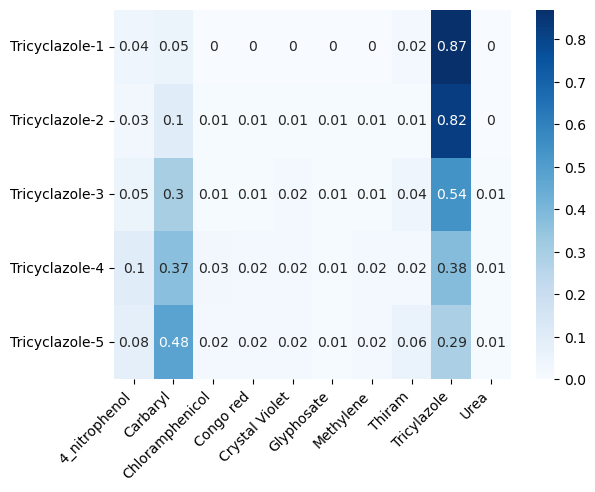

In [21]:
probabilities = []
Trycilazole_1 = ['Tricyclazole-1','Tricyclazole-2','Tricyclazole-3',
               'Tricyclazole-4','Tricyclazole-5']
for i in range(5):
    result = model_predict(X_test, y_test, ensemble_clf, path=Trycilazole[i])
    probabilities.append(result['Probability'])

probabilities_array = np.array(probabilities)
# print(probabilities_array)
import seaborn as sn
sn.heatmap(probabilities_array.reshape(5,10), annot= True, cmap= "Blues")
plt.xticks(np.arange(len(labels)) + 0.5, labels, rotation=45, ha="right")
plt.yticks(np.arange(len(Trycilazole_1)) + 0.5, Trycilazole_1, rotation=0)
# plt.xlabel("Predicted (%)")
# plt.ylabel("True label")
plt.savefig(f"./plots/{type(model).__name__}.png")


In [22]:
def plot_Tricylazole(paths, nrows, ncols, figsize):
    fig, axes = plt.subplots(nrows= nrows, ncols= ncols, figsize= figsize)
    axes = axes.flatten()

    for i, path in enumerate(paths):
        data = pd.read_csv(path, sep="\t")
        x = data.iloc[-1000:, 0].values
        y = data.iloc[-1000:, 1].values
        ax = axes[i]
        ax.set_xlabel("Raman Shift")
        ax.set_ylabel("a.u.")
        ax.plot(x, y)
    plt.tight_layout()  
    plt.show()


In [76]:
from decimal import Decimal
Cm = [] 
for i in Trycilazole:
    data = pd.read_csv(i, sep="\t")
    x = my_array = np.arange(10)
    y = data.iloc[[1885, 1391, 1670, 1407, 1421, 1577, 1878, 1512, 1892, 1596], 1].values
    y_1 = data.iloc[1851:1885, 1].values
    # print(y_1)
    min_y = np.min(y_1)
    print(min_y)
    delta = y[0] - np.min(y_1)
    cm = (np.log10(float(delta))- 5.58)/0.36
    # print(cm)
    Cm.append(10**(float(cm)))
print(Cm)

-85.124
-159.882
-150.878
-122.9
-164.225
[5.158138277319984e-07, 1.5085026168468492e-07, 4.258594955224027e-08, 1.1013836049862625e-08, 5.0076027773456985e-09]


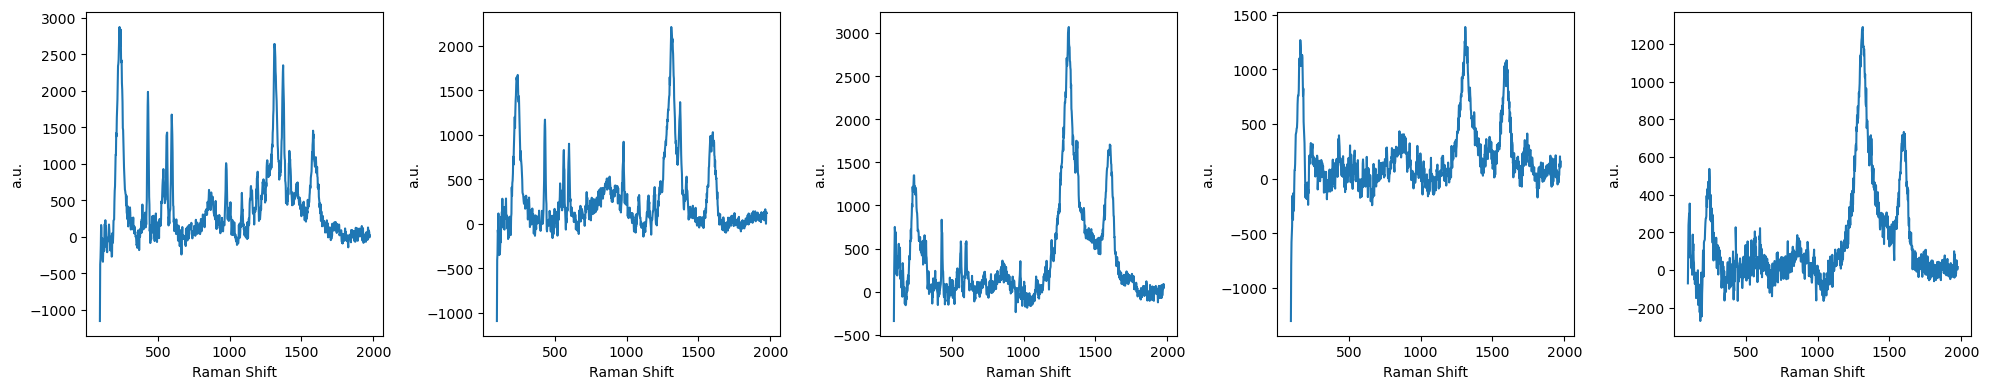

['Tricyclazole-1', 'Tricyclazole-2', 'Tricyclazole-3', 'Tricyclazole-4', 'Tricyclazole-5']
0.0000003693
0.0000001022
0.0000000211
0.0000000040
0.0000000011


In [59]:
plot_Tricylazole(paths = Trycilazole, nrows=1, ncols=5, figsize = (20, 4))
print(Trycilazole_1)
for i in Cm:
    print(f"{i:.10f}")

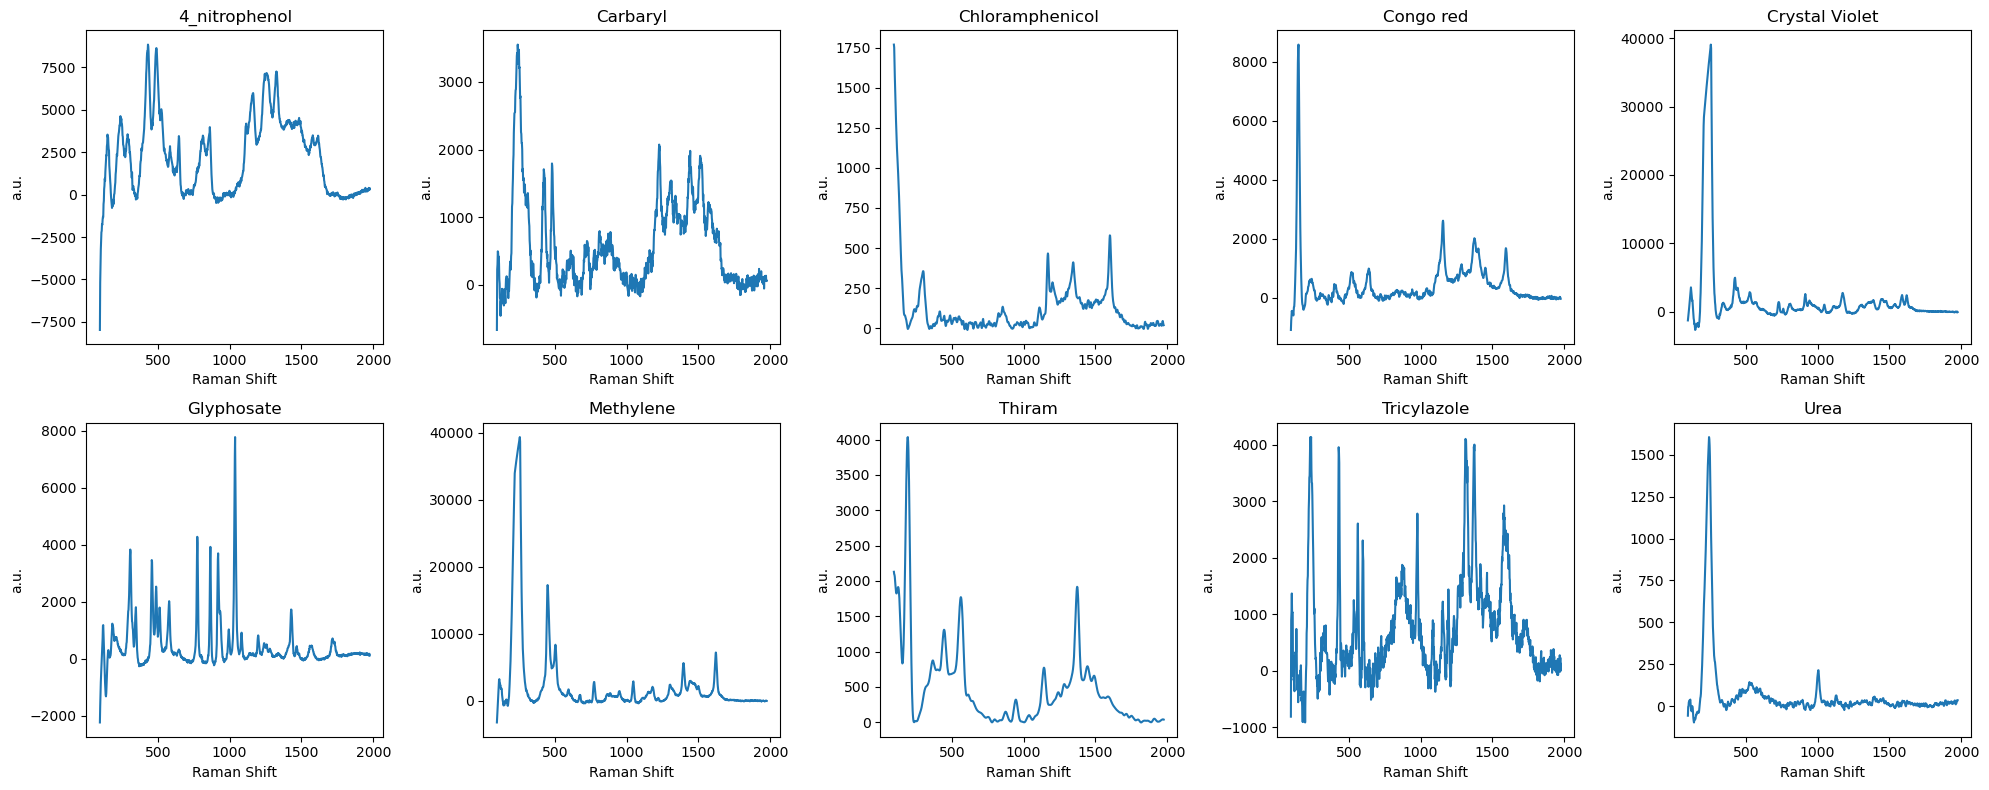

In [ ]:
plot_data(paths, labels, file_names[0], 2, 5, figsize = (20, 8))

# Feature extraction PCA and training

In [24]:
X_mean = np.mean(X)
U = U_for_pca(X_train, X_mean, n_components = 3)
X_train_PCA = extract_PCA(X_train, X_mean, n_components=3)
# X_test_PCA = pca(X_test, X_mean, U)
X_test_PCA = extract_PCA(X_test, X_mean, n_components=3)

In [56]:
Grid_search_model(X_train_PCA,y_train, cv = 3)

Best parameters for Logistic Regression: {'C': 10.0, 'penalty': 'l1', 'solver': 'liblinear'}, score: 0.63
Time taken for Logistic Regression: 0.08 seconds

Best parameters for SVM: {'C': 10.0, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'shrinking': True}, score: 0.73
Time taken for SVM: 0.24 seconds

Best parameters for KNN: {'algorithm': 'auto', 'metric': 'cosine', 'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}, score: 0.63
Time taken for KNN: 1.21 seconds

Best parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'best'}, score: 0.57
Time taken for Decision Tree: 0.37 seconds

Best parameters for Random Forest: {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200, 'random_state': 42}, score: 0.53
Time taken for Random Forest: 54.07 seconds

Best parameters for Naive Bayes: {'alpha': 0.01}, score: 0.17
Time taken for Naive Bayes: 0.

In [57]:
models = [LogisticRegression(C = 10, penalty = 'l1', solver = 'liblinear'),
          SVC(C = 10, degree = 2, gamma = 'scale', shrinking = True,  probability=True, kernel = 'linear'),
          KNeighborsClassifier(algorithm = 'auto',p = 1, weights = 'uniform', n_neighbors = 3, metric = 'euclidean'),
          DecisionTreeClassifier(criterion= 'gini', max_depth= 8, min_samples_leaf= 2, min_samples_split = 2, splitter= 'best',  random_state = 42),
          RandomForestClassifier(criterion = 'gini', max_depth = 2, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 50,  random_state = 42),
          BernoulliNB(alpha=0.1)]

In [58]:
for i, model in enumerate(models):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model.fit(X_train_PCA, y_train)
    file_name = f"./model/PCA/{type(models[i]).__name__}.pkl"
    save_model(file_name, model)


Model './model/PCA/LogisticRegression.pkl' already saved
Model './model/PCA/SVC.pkl' already saved
Model './model/PCA/KNeighborsClassifier.pkl' already saved
Model './model/PCA/DecisionTreeClassifier.pkl' already saved
Model './model/PCA/RandomForestClassifier.pkl' already saved
Model './model/PCA/BernoulliNB.pkl' already saved


Testing with LogisticRegression
Accuracy: 0.0000
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
[5. 5. 5. 1. 5. 4. 7. 8. 0. 4. 7. 5. 2. 7. 5. 5. 5. 8. 7. 4.]
[[0. 9. 3. 4. 8. 5. 2. 4. 6. 5. 2. 9. 7. 3. 0. 1. 8. 6. 1. 7.]]


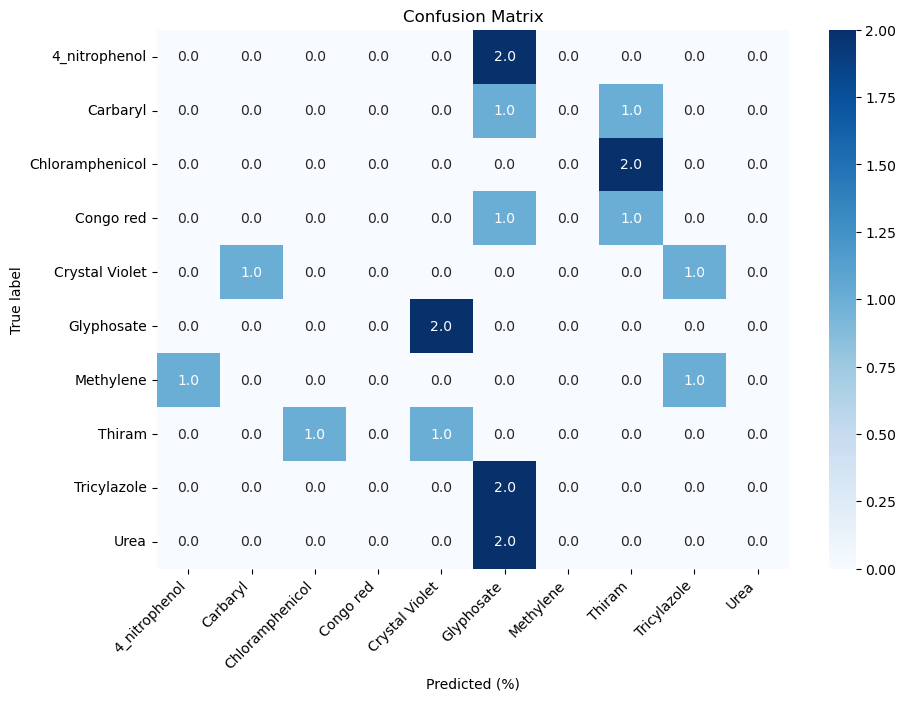

In [59]:
print(model_predict(X_test_PCA, y_test, models[0])['Predict'])
print(y_test.T)

# Feature extraction AutoEncoder and training

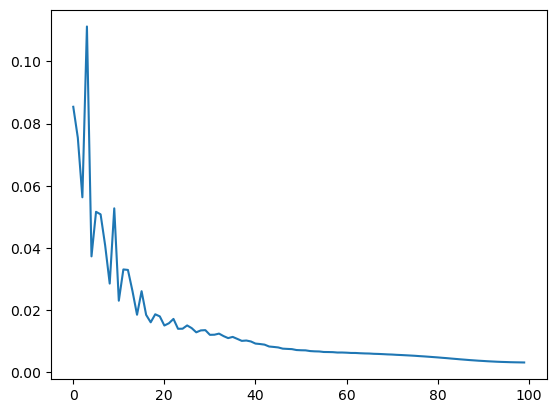

In [60]:
model = modelAE(X_train, out_features = 100, num_epochs = 100, learning_rate = 0.01)

In [61]:
X_train_AE = extractAE(model, X_train)
X_test_AE = extractAE(model, X_test)

In [62]:
Grid_search_model(X_train_AE,y_train, cv = 3)

Best parameters for Logistic Regression: {'C': 10.0, 'penalty': 'l1', 'solver': 'liblinear'}, score: 0.53
Time taken for Logistic Regression: 0.09 seconds

Best parameters for SVM: {'C': 10.0, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'shrinking': True}, score: 0.57
Time taken for SVM: 0.25 seconds

Best parameters for KNN: {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}, score: 0.57
Time taken for KNN: 1.48 seconds

Best parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 42, 'splitter': 'random'}, score: 0.53
Time taken for Decision Tree: 0.46 seconds

Best parameters for Random Forest: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50, 'random_state': 42}, score: 0.67
Time taken for Random Forest: 56.49 seconds

Best parameters for Naive Bayes: {'alpha': 0.01}, score: 0.57
Time taken for Naive Baye

In [63]:
models = [LogisticRegression(C = 10, penalty = 'l1', solver = 'liblinear'),
          SVC(C = 10, degree = 2, gamma = 'scale', shrinking = True,  probability=True, kernel = 'linear'),
          KNeighborsClassifier(algorithm = 'auto',p = 1, weights = 'uniform', n_neighbors = 3, metric = 'euclidean'),
          DecisionTreeClassifier(criterion= 'entropy', max_depth= 4, min_samples_leaf= 1, min_samples_split = 2, splitter= 'best',  random_state = 42),
          RandomForestClassifier(criterion = 'gini', max_depth = 6, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 100,  random_state = 42),
          BernoulliNB(alpha=0.01)]

In [64]:
for i, model in enumerate(models):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model.fit(X_train_AE, y_train)
    file_name = f"./model/AutoEncoder/{type(models[i]).__name__}.pkl"
    save_model(file_name, model)

Model './model/AutoEncoder/LogisticRegression.pkl' already saved
Model './model/AutoEncoder/SVC.pkl' already saved
Model './model/AutoEncoder/KNeighborsClassifier.pkl' already saved
Model './model/AutoEncoder/DecisionTreeClassifier.pkl' already saved
Model './model/AutoEncoder/RandomForestClassifier.pkl' already saved
Model './model/AutoEncoder/BernoulliNB.pkl' already saved


Testing with LogisticRegression
Accuracy: 0.2500
Precision: 0.1833
Recall: 0.2500
F1-score: 0.2067
[8. 1. 2. 6. 8. 2. 9. 6. 6. 2. 9. 2. 3. 7. 0. 1. 0. 6. 8. 9.]
[[0. 9. 3. 4. 8. 5. 2. 4. 6. 5. 2. 9. 7. 3. 0. 1. 8. 6. 1. 7.]]


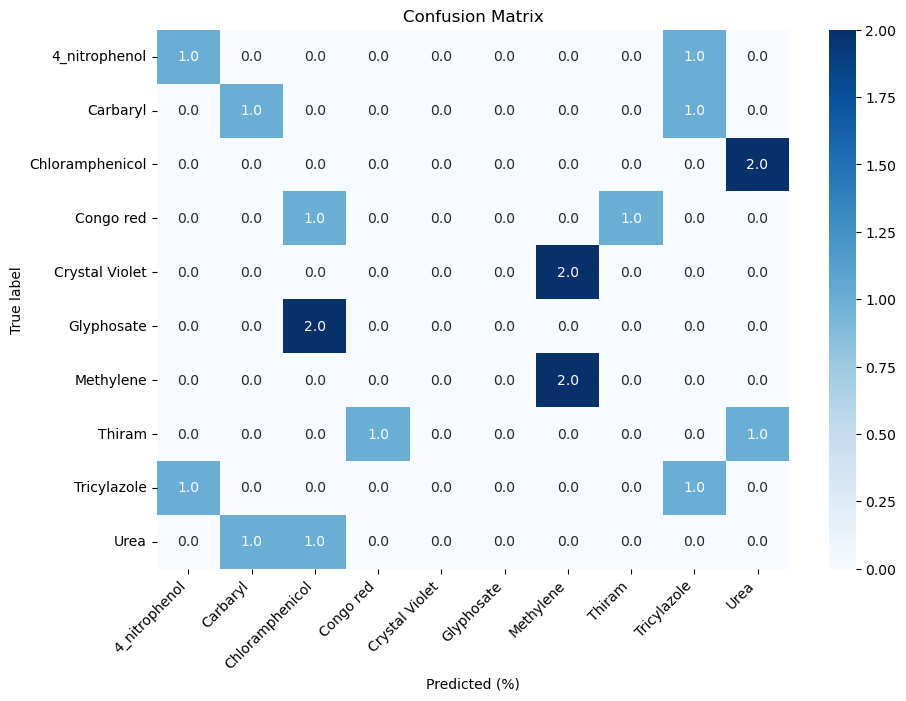

In [65]:
print(model_predict( X_test_AE, y_test, models[0])['Predict'])
print(y_test.T)

In [66]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, perplexity=30)  

X_tsne = tsne.fit_transform(X)


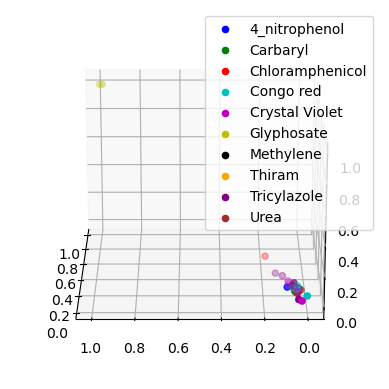

In [67]:
visualize(X,y, option = "3d",eval = 20, azim = 180, legend = True)

In [73]:
a = np.array([-10, 1, 20])
b = np.maximum(a,0)
c = Norm(a)
print(c)

[0.         0.36666667 1.        ]
